<a href="https://colab.research.google.com/github/sazio/Transients/blob/master/Python/Trajectories%26Levy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install traja

     |████████████████████████████████| 81kB 3.2MB/s 
  Created wheel for traja: filename=traja-0.2.3-cp36-none-any.whl size=82654 sha256=37fb485071a7376530d92fa170eda16e305d0645ca3fdb56f4c752ce435e57e1
  Stored in directory: /root/.cache/pip/wheels/03/90/1a/84e9bb38d095fd62bff931244bb861c2eeec6f3b79dd03d945
Successfully built traja


In [2]:
import numpy as np
import pandas as pd 
import traja
import glob
import re
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
path_to_files = "drive/MyDrive/JamesSimoneSpatial/TrackFilesCue/CueCsv/Track/"

trackFiles = []
trackFiles = sorted(glob.glob(path_to_files + '*Track.csv'))

In [5]:
probeFiles = []

# Filtering probe trials 
# if probeFilter = True, probetrials are not used in the future statistics
# if probeFilter = False, probetrials are going to take part in the stats
probeFilter = True 

if probeFilter == True:
    regExpr = re.compile(r'p_Track')
    probeFiles = list(filter(lambda i : regExpr.search(i), trackFiles))
    trackFiles = list(filter(lambda i : not regExpr.search(i), trackFiles))
    
else : 
    trackFiles = trackFiles 

In [6]:
trackData = []
for i in tqdm(range(0,len(trackFiles))) : 
    trackData.append(pd.read_csv(trackFiles[i], names = ["time", "x", "y", "HeadAngle","EODRate","DistanceXEODPulse",
                                                         "HeadSpeed", "DistanceXESCAN"]))
    """_Track.csv files:
    Columns: T(s), X(m), Y(m), A(deg), R(Hz), D(m), V(m/s), S(m):
    T: camera frame time
    X: x coordinate of the head tip @ grid frame of reference
    Y: y coordinate of the head tip @ grid frame of reference
    A: head orientation
    R: EOD rate
    D: Distance per EOD pulse (=1/sampling_density)
    V: Head speed (m/s, signed)
    S: Distance per Escan (=1/escan_density)"""

In [7]:
# Creating list of probe Data as list of pandas dataframes 
probeData = []
for i in tqdm(range(0,len(probeFiles))) : 
    probeData.append(pd.read_csv(probeFiles[i], names = ["time", "x", "y", "HeadAngle","EODRate","DistanceXEODPulse",
                                                         "HeadSpeed", "DistanceXESCAN"]))

In [8]:
traja_steps = []
for i in tqdm(range(0, len(trackFiles[:19]))):

  trajaDF = traja.TrajaDataFrame(trackData[i])
  pivot = traja.step_lengths(trajaDF).dropna()
  pivot = pivot[pivot!= 0]

  traja_steps.append(pivot)

In [17]:
early_steps = traja_steps[0]

for i in tqdm(range(1,17)):
  early_steps = early_steps.append(traja_steps[i], ignore_index= True)

In [10]:
import scipy.stats as st

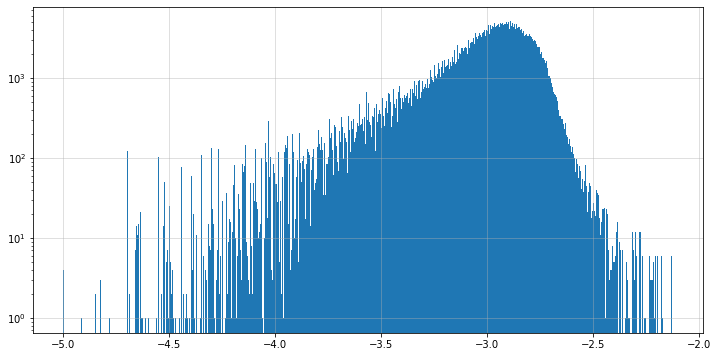

In [11]:
plt.figure(figsize = (12,6))
counts, bins, bars = plt.hist(np.log10(early_steps), bins = int(np.sqrt(early_steps.shape[0])), log = True)
plt.grid(alpha = 0.5)

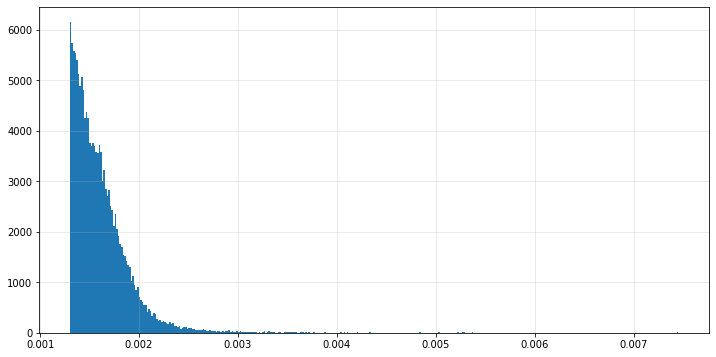

In [19]:
early_steps = early_steps[early_steps > 0.0013] 
plt.figure(figsize = (12,6))
counts, bins, bars = plt.hist(early_steps, bins = int(np.sqrt(early_steps.shape[0])))
plt.grid(alpha = 0.3)
plt.savefig("distrib_early.png")

In [14]:
pconv = lambda mu, sigma: ( mu - sigma * beta * np.tan(np.pi * alpha / 2.0), sigma)
alpha, beta, mu, sigma = pconv(*st.levy._fitstart(bins))
print(alpha, beta, mu, sigma)

/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:2407: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


NameError: ignored

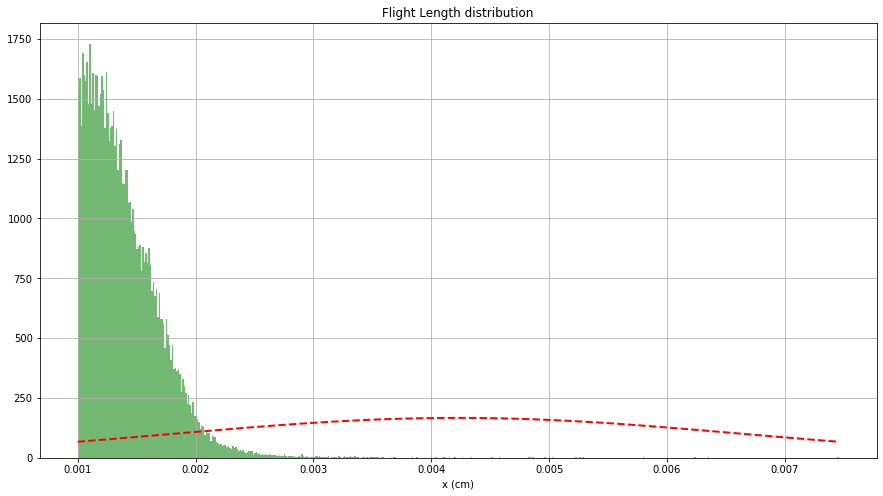

In [ ]:
plt.figure(figsize = (15,8))
#n, bins, patches = plt.hist(x, int(np.sqrt(x.shape[0])), density = True, facecolor='green', alpha=0.55)
counts, bins, bars = plt.hist(early_steps, bins = int(np.sqrt(early_steps.shape[0])), density = True, facecolor='green', alpha=0.55)
# add a 'best fit' line
#y = norm.pdf( bins, *norm._fitstart(bins))
y = st.levy_stable.pdf(bins,*st.levy_stable._fitstart(bins))

l = plt.plot(bins, y, 'r--', linewidth=2)


plt.title("Flight Length distribution")
plt.xlabel('x (cm)')
plt.ylabel('')

plt.grid(True)

plt.show()